<a href="https://colab.research.google.com/github/techsouravganguly/English_Text_to_German_Text/blob/main/Neural_Machine_Translation_English_to_German.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing the Modules

In [1]:
#importing require modules 

from termcolor import colored
import random
import numpy as np
import os
!pip install -q -U trax
import trax

import trax
from trax import layers as tl
from trax.fastmath import numpy as fastnp
from trax.supervised import training

!pip list | grep trax

     |████████████████████████████████| 629 kB 7.4 MB/s 
     |████████████████████████████████| 152 kB 13.7 MB/s 
     |████████████████████████████████| 4.3 MB 13.7 MB/s 
     |████████████████████████████████| 366 kB 60.3 MB/s 
     |████████████████████████████████| 4.0 MB 55.2 MB/s 
     |████████████████████████████████| 54 kB 3.7 MB/s 
     |████████████████████████████████| 249 kB 47.9 MB/s 
     |████████████████████████████████| 1.2 MB 43.8 MB/s 
     |████████████████████████████████| 2.6 MB 53.9 MB/s 
     |████████████████████████████████| 895 kB 53.7 MB/s 
     |████████████████████████████████| 3.3 MB 45.6 MB/s 
     |████████████████████████████████| 636 kB 58.6 MB/s 
trax                          1.3.9


Importing the Data

In [2]:
# setting the generator function for the eval and train set
train_stream_fn = trax.data.TFDS('opus/medical',
                                 data_dir='./data/',
                                 keys=('en', 'de'),
                                 eval_holdout_size=0.01, # 1% for eval
                                 train=True
                                )

eval_stream_fn = trax.data.TFDS('opus/medical',
                                data_dir='./data/',
                                keys=('en', 'de'),
                                eval_holdout_size=0.01, # 1% for eval                                
                                train=False
                               )

/usr/local/lib/python3.7/dist-packages/jax/lib/xla_bridge.py:374: UserWarning: jax.host_id has been renamed to jax.process_index. This alias will eventually be removed; please update your code.
  "jax.host_id has been renamed to jax.process_index. This alias "
/usr/local/lib/python3.7/dist-packages/jax/lib/xla_bridge.py:387: UserWarning: jax.host_count has been renamed to jax.process_count. This alias will eventually be removed; please update your code.
  "jax.host_count has been renamed to jax.process_count. This alias "


Dataset opus downloaded and prepared to ./data/opus/medical/0.1.0. Subsequent calls will reuse this data.


Seeing the raw data 

In [3]:

# seeing some dataset from eval and train set
train_stream = train_stream_fn()
print(colored('train data (en, de) tuple:', 'red'), next(train_stream))
print()

eval_stream = eval_stream_fn()
print(colored('eval data (en, de) tuple:', 'red'), next(eval_stream))

train data (en, de) tuple: (b'Tel: +421 2 57 103 777\n', b'Tel: +421 2 57 103 777\n')

eval data (en, de) tuple: (b'Subcutaneous use and intravenous use.\n', b'Subkutane Anwendung und intraven\xc3\xb6se Anwendung.\n')


Setting The Vocab

In [4]:
#setting up the Vocab for the tokenize train and eval set
VOCAB_FILE = 'ende_32k.subword'
VOCAB_DIR = '/content/drive/MyDrive/data/'

# Tokenize the dataset.
tokenized_train_stream = trax.data.Tokenize(vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR)(train_stream)
tokenized_eval_stream = trax.data.Tokenize(vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR)(eval_stream)

Adding End of the Sentence in each input and target

In [5]:
# adding EOs at the end of each sentence.

EOS = 1

def append_eos(stream):
  for (inputs, targets) in stream:
    inputs = list(inputs) + [EOS]
    targets = list(targets) + [EOS]
    yield np.array(inputs), np.array(targets)

tokenized_train_stream = append_eos(tokenized_train_stream)
tokenized_eval_stream = append_eos(tokenized_eval_stream) 

Cutting the all sentences to 256 length

In [6]:
# Filter too long sentences to not run out of memory.
# length_keys=[0, 1] means we filter both English and German sentences, so
# both much be not longer that 256 tokens for training / 512 for eval.

filtered_train_stream = trax.data.FilterByLength(max_length=256, length_keys=[0, 1])(tokenized_train_stream)
filtered_eval_stream = trax.data.FilterByLength(max_length=256, length_keys=[0, 1])(tokenized_eval_stream)

#printing the sample input-target pair
train_input, train_target = next(filtered_train_stream)
print(train_input)
print(train_target)

[ 2538  2248    30 12114 23184 16889     5     2 20852  6456 20592  5812
  3932    96  5178  3851    30  7891  3550 30650  4729   992     1]
[ 1872    11  3544    39  7019 17877 30432    23  6845    10 14222    47
  4004    18 21674     5 27467  9513   920   188 10630    18  3550 30650
  4729   992     1]


Helper function for Tokenizing and Detokenizing

In [7]:
# setting up for the tokenizing and detokenizing 
# of the sentences
def tokenize(input_str, vocab_file=None, vocab_dir = None):
  """Encodes a string into an array of integer
  Args:
    input_str (str) : human-readable string
    vocab_file (str): filename of vocab
    vocab_dir (str) : path of the vocab directory
  Retruns : 
    numpy.ndarray: tokenized version of the input string
  """
  EOS = 1
  inputs = next(trax.data.tokenize(iter([input_str]),
                                   vocab_file = vocab_file, vocab_dir = vocab_dir))
  inputs = list(inputs) + [EOS]
  batch_inputs = np.reshape(np.array(inputs), [1, -1])
  return batch_inputs

def detokenize(integers, vocab_file = None, vocab_dir=None):
  """Detokenize the array of integer to human readable string
  Args:
    integers (np.ndarray): array of integers
    vocab_file (str): filename of vocab
    vocab_dir (str) : path of the vocab directory

  Return:
    str: the decoded sentence.
  """
  integers = list(np.squeeze(integers))
  EOS = 1
  if EOS in integers:
    integers = integers[:integers.index(EOS)]
  
  return trax.data.detokenize(integers, vocab_file=vocab_file, vocab_dir= vocab_dir)
  


Seeing the result tokenize and detokenize

In [8]:
# Detokenize an input-target pair of tokenized sentences
print(colored(f'Single detokenized example input:', 'red'), detokenize(train_input, vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR))
print(colored(f'Single detokenized example target:', 'red'), detokenize(train_target, vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR))
print()

# Tokenize and detokenize a word that is not explicitly saved in the vocabulary file.
# See how it combines the subwords -- 'hell' and 'o'-- to form the word 'hello'.
print(colored(f"tokenize('hello'): ", 'green'), tokenize('hello', vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR))
print(colored(f"detokenize([17332, 140, 1]): ", 'green'), detokenize([17332, 140, 1], vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR))

Single detokenized example input: During treatment with olanzapine, adolescents gained significantly more weight compared with adults.

Single detokenized example target: Während der Behandlung mit Olanzapin nahmen die Jugendlichen im Vergleich zu Erwachsenen signifikant mehr Gewicht zu.


tokenize('hello'):  [[17332   140     1]]
detokenize([17332, 140, 1]):  hello


Implementing the Buckting 

In [9]:
# Bucketing to create streams of batches.

# Buckets are defined in terms of boundaries and batch sizes.
# Batch_sizes[i] determines the batch size for items with length < boundaries[i]
# So below, we'll take a batch of 256 sentences of length < 8, 128 if length is
# between 8 and 16, and so on -- and only 2 if length is over 512.

boundaries = [8, 16, 32, 64, 128, 256, 512]
batch_sizes = [256, 128, 64, 32, 16, 8, 4, 2]

#createing generator for bucketing
train_batch_stream = trax.data.BucketByLength(boundaries,
                                              batch_sizes, length_keys=[0,1]
                                              )(filtered_train_stream)
eval_batch_stream = trax.data.BucketByLength(boundaries,
                                              batch_sizes, length_keys=[0,1]
                                              )(filtered_eval_stream)

# Add masking for the padding (0s).
train_batch_stream = trax.data.AddLossWeights(id_to_mask=0)(train_batch_stream)
eval_batch_stream = trax.data.AddLossWeights(id_to_mask=0)(eval_batch_stream)


Exploting the data 

In [10]:
input_batch, target_batch, mask_batch = next(train_batch_stream)

# let's see the data type of a batch
print("input_batch data type: ", type(input_batch))
print("target_batch data type: ", type(target_batch))

# let's see the shape of this particular batch (batch length, sentence length)
print("input_batch shape: ", input_batch.shape)
print("target_batch shape: ", target_batch.shape)

input_batch data type:  <class 'numpy.ndarray'>
target_batch data type:  <class 'numpy.ndarray'>
input_batch shape:  (32, 64)
target_batch shape:  (32, 64)


In [11]:
# pick a random index less than the batch size.
index = random.randrange(len(input_batch))

# use the index to grab an entry from the input and target batch
print(colored('THIS IS THE ENGLISH SENTENCE: \n', 'red'), detokenize(input_batch[index], vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR), '\n')
print(colored('THIS IS THE TOKENIZED VERSION OF THE ENGLISH SENTENCE: \n ', 'red'), input_batch[index], '\n')
print(colored('THIS IS THE GERMAN TRANSLATION: \n', 'red'), detokenize(target_batch[index], vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR), '\n')
print(colored('THIS IS THE TOKENIZED VERSION OF THE GERMAN TRANSLATION: \n', 'red'), target_batch[index], '\n')

THIS IS THE ENGLISH SENTENCE: 
 Kidneys and urinary tract (no effects were found to be common); uncommon: blood in the urine, proteins in the urine, sugar in the urine; rare: urge to pass urine, kidney pain, passing urine frequently.
 

THIS IS THE TOKENIZED VERSION OF THE ENGLISH SENTENCE: 
  [ 5381 17607  3093     8  8670  6086   105 19166     5    50   154  1743
   152  1103     9    32   568  8076 19124  6847    64  6196     6     4
  8670   510     2 13355   823     6     4  8670   510     2  4968     6
     4  8670   510   115  7227    64  7628     9  2685  8670   510     2
 12220  5509 12095     2 19632  8670   510  7326  3550 30650  4729   992
     1     0     0     0] 

THIS IS THE GERMAN TRANSLATION: 
 Harndrang, Nierenschmerzen, häufiges Wasserlassen.
 

THIS IS THE TOKENIZED VERSION OF THE GERMAN TRANSLATION: 
 [ 5135 14970  2920     2  6262  4594 27552    28     2 20052    33  3736
   530  3550 30650  4729   992     1     0     0     0     0     0     0
     0     0     0 

**Neural Machine Translation with
Attention**

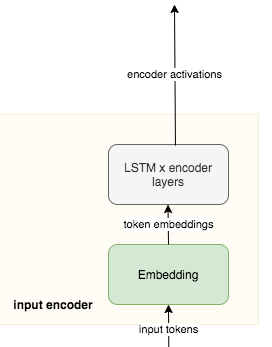


Implementing the input_encoder_function

In [12]:
def input_encoder_fn(input_vocab_size, d_model, n_encoder_layers):
  """Args:
        input_vocab_size: int: vocab size of the input
        d_model: int:  depth of embedding (n_units in the LSTM cell)
        n_encoder_layers: int: number of LSTM layers in the encoder
    Returns:
        tl.Serial: The input encoder
  """ 
  input_encoder = tl.Serial(
      tl.Embedding(input_vocab_size, d_model),
      [tl.LSTM(d_model) for _ in range(n_encoder_layers)]
  )
  return input_encoder

Pre-attention decoder
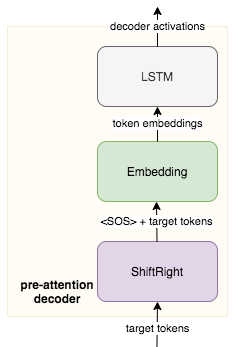

In [13]:
def pre_attention_decoder_fn(mode, target_vocab_size, d_model):
  """ Pre-attention decoder runs on the targets and creates
    activations that are used as queries in attention.
    
    Args:
        mode: str: 'train' or 'eval'
        target_vocab_size: int: vocab size of the target
        d_model: int:  depth of embedding (n_units in the LSTM cell)
    Returns:
        tl.Serial: The pre-attention decoder
  """
  pre_attention_decoder = tl.Serial(
        tl.ShiftRight(1, mode = mode),
        tl.Embedding(target_vocab_size, d_model),
        tl.LSTM(d_model)
  )
  return pre_attention_decoder

Prepare attention input

In [14]:
def prepare_attention_input(encoder_activaions, decoder_activations, inputs):
  """Prepare queries, keys, values and mask for attention.
    
  Args:
        encoder_activations fastnp.array(batch_size, padded_input_length, d_model): output from the input encoder
        decoder_activations fastnp.array(batch_size, padded_input_length, d_model): output from the pre-attention decoder
        inputs fastnp.array(batch_size, padded_input_length): input tokens
    
    Returns:
        queries, keys, values and mask for attention.
  """
  keys = encoder_activaions
  values = encoder_activaions
  queries = decoder_activations
  mask = inputs > 0
  mask = fastnp.reshape(mask, (mask.shape[0], 1, 1, mask.shape[1]))
  mask = mask + fastnp.zeros((1, 1, decoder_activations.shape[1], 1))

  return queries, keys, values, mask

Final implemention for Neural Machine Translation Model 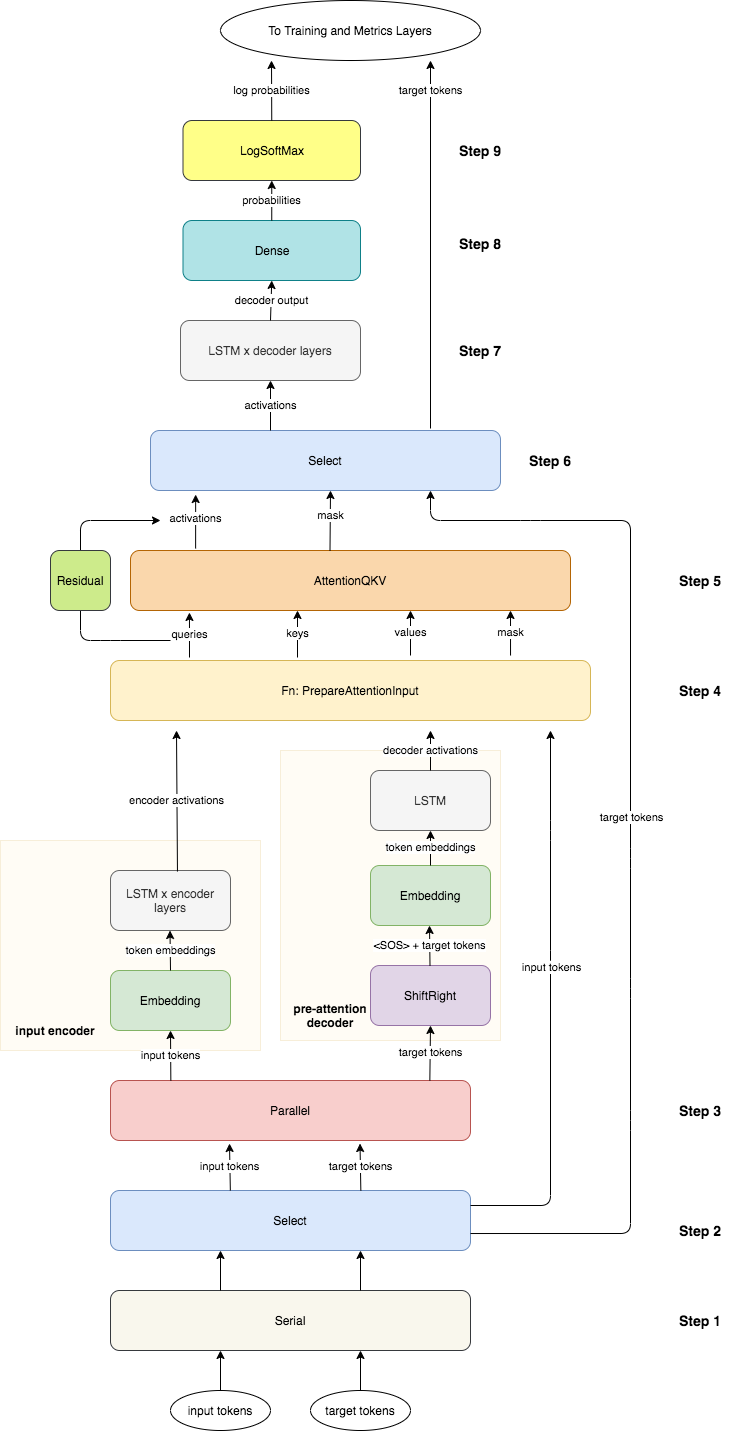

In [15]:
def NMTAttn(input_vocab_size=33300,
            target_vocab_size=33300,
            d_model=1024,
            n_encoder_layers=2,
            n_decoder_layers=2,
            n_attention_heads=4,
            attention_dropout=0.0,
            mode='train'):
    """Returns an LSTM sequence-to-sequence model with attention.

    The input to the model is a pair (input tokens, target tokens), e.g.,
    an English sentence (tokenized) and its translation into German (tokenized).

    Args:
    input_vocab_size: int: vocab size of the input
    target_vocab_size: int: vocab size of the target
    d_model: int:  depth of embedding (n_units in the LSTM cell)
    n_encoder_layers: int: number of LSTM layers in the encoder
    n_decoder_layers: int: number of LSTM layers in the decoder after attention
    n_attention_heads: int: number of attention heads
    attention_dropout: float, dropout for the attention layer
    mode: str: 'train', 'eval' or 'predict', predict mode is for fast inference

    Returns:
    A LSTM sequence-to-sequence model with attention.
    """
    input_encoder = input_encoder_fn(input_vocab_size, d_model, n_encoder_layers)

    
    pre_attention_decoder = pre_attention_decoder_fn(mode, target_vocab_size, d_model)

    model = tl.Serial( 
      
      tl.Select([0, 1, 0, 1]),
      tl.Parallel(input_encoder, pre_attention_decoder),
      tl.Fn('PrepareAttentionInput', prepare_attention_input, n_out=4),
      tl.Residual(tl.AttentionQKV(d_model, n_heads=n_attention_heads, dropout=attention_dropout, mode=mode)),
      tl.Select([0, 2]),
      [tl.LSTM(d_model) for _ in range(n_decoder_layers)],
      tl.Dense(input_vocab_size),
      tl.LogSoftmax()
    )
    
    return model

In [16]:
# print your model
model = NMTAttn()
print(model)

Serial_in2_out2[
  Select[0,1,0,1]_in2_out4
  Parallel_in2_out2[
    Serial[
      Embedding_33300_1024
      LSTM_1024
      LSTM_1024
    ]
    Serial[
      Serial[
        ShiftRight(1)
      ]
      Embedding_33300_1024
      LSTM_1024
    ]
  ]
  PrepareAttentionInput_in3_out4
  Serial_in4_out2[
    Branch_in4_out3[
      None
      Serial_in4_out2[
        _in4_out4
        Serial_in4_out2[
          Parallel_in3_out3[
            Dense_1024
            Dense_1024
            Dense_1024
          ]
          PureAttention_in4_out2
          Dense_1024
        ]
        _in2_out2
      ]
    ]
    Add_in2
  ]
  Select[0,2]_in3_out2
  LSTM_1024
  LSTM_1024
  Dense_33300
  LogSoftmax
]


**Training**

In [17]:
def train_task_function(train_batch_stream):
    """Returns a trax.training.TrainTask object.

    Args:
    train_batch_stream generator: labeled data generator

    Returns:
    A trax.training.TrainTask object.
    """
    return training.TrainTask(
        labeled_data= train_batch_stream,
        loss_layer= tl.CrossEntropyLoss(),
        optimizer= trax.optimizers.Adam(0.01),
        lr_schedule= trax.lr.warmup_and_rsqrt_decay(1000, 0.01),
        n_steps_per_checkpoint= 10

    )

In [18]:
train_task = train_task_function(train_batch_stream)

**Evalution of the NMT**

In [19]:
eval_task = training.EvalTask(
    
    ## use the eval batch stream as labeled data
    labeled_data=eval_batch_stream,
    
    ## use the cross entropy loss and accuracy as metrics
    metrics=[tl.CrossEntropyLoss(), tl.Accuracy()],
)


**LOOPING OVER**

In [20]:
# define the output directory
output_dir = 'output_dir/'

# remove old model if it exists. restarts training.
!rm -f ~/output_dir/model.pkl.gz  

# define the training loop
training_loop = training.Loop(NMTAttn(mode='train'),
                              train_task, #[train_task],
                              eval_tasks=[eval_task],
                              output_dir=output_dir)

/usr/local/lib/python3.7/dist-packages/jax/lib/xla_bridge.py:374: UserWarning: jax.host_id has been renamed to jax.process_index. This alias will eventually be removed; please update your code.
  "jax.host_id has been renamed to jax.process_index. This alias "
/usr/local/lib/python3.7/dist-packages/jax/lib/xla_bridge.py:387: UserWarning: jax.host_count has been renamed to jax.process_count. This alias will eventually be removed; please update your code.
  "jax.host_count has been renamed to jax.process_count. This alias "


In [ ]:
training_loop.run(10)

/usr/local/lib/python3.7/dist-packages/jax/lib/xla_bridge.py:374: UserWarning: jax.host_id has been renamed to jax.process_index. This alias will eventually be removed; please update your code.
  "jax.host_id has been renamed to jax.process_index. This alias "



Step      1: Total number of trainable weights: 148492820
Step      1: Ran 1 train steps in 160.17 secs
Step      1: train CrossEntropyLoss |  10.42407608
Step      1: eval  CrossEntropyLoss |  10.42009068
Step      1: eval          Accuracy |  0.00000000

Step     10: Ran 9 train steps in 431.74 secs
Step     10: train CrossEntropyLoss |  10.26556110
Step     10: eval  CrossEntropyLoss |  9.98338699
Step     10: eval          Accuracy |  0.02429765


**Testing**

In [22]:
# instantiate the model we built in eval mode
model = NMTAttn(mode='eval')

# initialize weights from a pre-trained model
model.init_from_file("/content/drive/MyDrive/data/model.pkl.gz", weights_only=True)
model = tl.Accelerate(model)

**Decoding**

In [24]:
def next_symbol(NMTAttn, input_tokens, cur_output_tokens, temperature):
    """Returns the index of the next token.

    Args:
        NMTAttn (tl.Serial): An LSTM sequence-to-sequence model with attention.
        input_tokens (np.ndarray 1 x n_tokens): tokenized representation of the input sentence
        cur_output_tokens (list): tokenized representation of previously translated words
        temperature (float): parameter for sampling ranging from 0.0 to 1.0.
            0.0: same as argmax, always pick the most probable token
            1.0: sampling from the distribution (can sometimes say random things)

    Returns:
        int: index of the next token in the translated sentence
        float: log probability of the next symbol
    """

    # set the length of the current output tokens
    token_length = len(cur_output_tokens)
    
    # calculate next power of 2 for padding length 
    padded_length = 2**int(np.ceil(np.log2(token_length + 1)))

    # pad cur_output_tokens up to the padded_length
    padded = cur_output_tokens + [0]*(padded_length-token_length)
    
    # model expects the output to have an axis for the batch size in front so
    # convert `padded` list to a numpy array with shape (1, <padded_length>)
    padded_with_batch = np.expand_dims(np.array(padded),axis=0)

    # get the model prediction
    output, _ = NMTAttn((input_tokens,padded_with_batch))
    
    # get log probabilities from the last token output
    log_probs = output[0,token_length,:]

    # get the next symbol by getting a logsoftmax sample (*hint: cast to an int)
    symbol = int(tl.logsoftmax_sample(log_probs, temperature))  
    return symbol, float(log_probs[symbol])

In [25]:
def sampling_decode(input_sentence, NMTAttn = None, temperature=0.0, vocab_file=None, vocab_dir=None, next_symbol=next_symbol, tokenize=tokenize, detokenize=detokenize):
    """Returns the translated sentence.

    Args:
        input_sentence (str): sentence to translate.
        NMTAttn (tl.Serial): An LSTM sequence-to-sequence model with attention.
        temperature (float): parameter for sampling ranging from 0.0 to 1.0.
            0.0: same as argmax, always pick the most probable token
            1.0: sampling from the distribution (can sometimes say random things)
        vocab_file (str): filename of the vocabulary
        vocab_dir (str): path to the vocabulary file

    Returns:
        tuple: (list, str, float)
            list of int: tokenized version of the translated sentence
            float: log probability of the translated sentence
            str: the translated sentence
    """
    # encode the input sentence
    input_tokens = tokenize(input_sentence, vocab_file=vocab_file, vocab_dir=vocab_dir)
    
    # initialize the list of output tokens
    cur_output_tokens = []
    
    # initialize an integer that represents the current output index
    cur_output = 0
    
    # Set the encoding of the "end of sentence" as 1
    EOS = 1
    
    # check that the current output is not the end of sentence token
    while cur_output != EOS:
        
        # update the current output token by getting the index of the next word (hint: use next_symbol)
        cur_output, log_prob = next_symbol(NMTAttn, input_tokens, cur_output_tokens, temperature)
        
        # append the current output token to the list of output tokens
        cur_output_tokens.append(cur_output)        
    
    # detokenize the output tokens
    sentence = detokenize(cur_output_tokens,vocab_file=vocab_file, vocab_dir=vocab_dir)
    return cur_output_tokens, log_prob, sentence

**RESULTS**

In [26]:
sampling_decode("I love languages.", NMTAttn=model, temperature=0.0, vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR)

([161, 12202, 5112, 3, 1], -0.0001735687255859375, 'Ich liebe Sprachen.')

In [27]:
def greedy_decode_test(sentence, NMTAttn=None, vocab_file=None, vocab_dir=None, sampling_decode=sampling_decode, next_symbol=next_symbol, tokenize=tokenize, detokenize=detokenize):
    """Prints the input and output of our NMTAttn model using greedy decode

    Args:
        sentence (str): a custom string.
        NMTAttn (tl.Serial): An LSTM sequence-to-sequence model with attention.
        vocab_file (str): filename of the vocabulary
        vocab_dir (str): path to the vocabulary file

    Returns:
        str: the translated sentence
    """
    
    _,_, translated_sentence = sampling_decode(sentence, NMTAttn=NMTAttn, vocab_file=vocab_file, vocab_dir=vocab_dir, next_symbol=next_symbol, tokenize=tokenize, detokenize=detokenize)
    
    print("English: ", sentence)
    print("German: ", translated_sentence)
    
    return translated_sentence

In [28]:
# put a custom string here
your_sentence = 'where are you going'

greedy_decode_test(your_sentence, NMTAttn=model, vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR);

English:  where are you going
German:  wo man sich hinzieht.


In [29]:
greedy_decode_test('I am almost done with neural machine translation', model, vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR);

English:  I am almost done with neural machine translation
German:  Ich bin fast mit Neutralen Maschine zusammengearbeitet.


**Using the Minimum Bayes-Risk Decoding**

In [30]:
def generate_samples(sentence, n_samples, NMTAttn=None, temperature=0.6, vocab_file=None, vocab_dir=None, sampling_decode=sampling_decode, next_symbol=next_symbol, tokenize=tokenize, detokenize=detokenize):
    """Generates samples using sampling_decode()

    Args:
        sentence (str): sentence to translate.
        n_samples (int): number of samples to generate
        NMTAttn (tl.Serial): An LSTM sequence-to-sequence model with attention.
        temperature (float): parameter for sampling ranging from 0.0 to 1.0.
            0.0: same as argmax, always pick the most probable token
            1.0: sampling from the distribution (can sometimes say random things)
        vocab_file (str): filename of the vocabulary
        vocab_dir (str): path to the vocabulary file
        
    Returns:
        tuple: (list, list)
            list of lists: token list per sample
            list of floats: log probability per sample
    """
    # define lists to contain samples and probabilities
    samples, log_probs = [], []

    # run a for loop to generate n samples
    for _ in range(n_samples):
        
        # get a sample using the sampling_decode() function
        sample, logp, _ = sampling_decode(sentence, NMTAttn, temperature, vocab_file=vocab_file, vocab_dir=vocab_dir, next_symbol=next_symbol)
        
        # append the token list to the samples list
        samples.append(sample)
        
        # append the log probability to the log_probs list
        log_probs.append(logp)
                
    return samples, log_probs

In [31]:
# generate 4 samples with the default temperature (0.6)
generate_samples('how are you today?', 4, model, vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR)

([[595, 119, 67, 352, 102, 1],
  [595, 30166, 705, 12300, 102, 1],
  [595, 75, 67, 352, 102, 1],
  [595, 75, 67, 352, 102, 1]],
 [-1.33514404296875e-05,
  -1.33514404296875e-05,
  -3.814697265625e-06,
  -3.814697265625e-06])

Comparing overlaps

In [32]:
def jaccard_similarity(candidate, reference):
    """Returns the Jaccard similarity between two token lists

    Args:
        candidate (list of int): tokenized version of the candidate translation
        reference (list of int): tokenized version of the reference translation

    Returns:
        float: overlap between the two token lists
    """
    
    # convert the lists to a set to get the unique tokens
    can_unigram_set, ref_unigram_set = set(candidate), set(reference)  
    
    # get the set of tokens common to both candidate and reference
    joint_elems = can_unigram_set.intersection(ref_unigram_set)
    
    # get the set of all tokens found in either candidate or reference
    all_elems = can_unigram_set.union(ref_unigram_set)
    
    # divide the number of joint elements by the number of all elements
    overlap = len(joint_elems) / len(all_elems)
    
    return overlap

In [33]:
# for making a frequency table easily
from collections import Counter

def rouge1_similarity(system, reference):
    """Returns the ROUGE-1 score between two token lists

    Args:
        system (list of int): tokenized version of the system translation
        reference (list of int): tokenized version of the reference translation

    Returns:
        float: overlap between the two token lists
    """    
    
    # make a frequency table of the system tokens (hint: use the Counter class)
    sys_counter = Counter(system)
    
    # make a frequency table of the reference tokens (hint: use the Counter class)
    ref_counter = Counter(reference)
    
    # initialize overlap to 0
    overlap = 0
    
    # run a for loop over the sys_counter object (can be treated as a dictionary)
    for token in sys_counter:
        
        # lookup the value of the token in the sys_counter dictionary (hint: use the get() method)
        token_count_sys = sys_counter.get(token, 0)
        
        # lookup the value of the token in the ref_counter dictionary (hint: use the get() method)
        token_count_ref = ref_counter.get(token, 0)
        
        # update the overlap by getting the smaller number between the two token counts above
        overlap += min(token_count_sys, token_count_ref)
    
    # get the precision
    precision = overlap/len(system)
    
    # get the recall
    recall = overlap/len(reference)
    
    if precision + recall != 0: 
        rouge1_score = 2 * (precision * recall)/ (precision + recall)
    else:
        rouge1_score = 0 
    return rouge1_score

Overall Score

In [34]:
def average_overlap(similarity_fn, samples, *ignore_params):
    """Returns the arithmetic mean of each candidate sentence in the samples

    Args:
        similarity_fn (function): similarity function used to compute the overlap
        samples (list of lists): tokenized version of the translated sentences
        *ignore_params: additional parameters will be ignored

    Returns:
        dict: scores of each sample
            key: index of the sample
            value: score of the sample
    """  
    
    # initialize dictionary
    scores = {}
    
    # run a for loop for each sample
    for index_candidate, candidate in enumerate(samples):    
        # initialize overlap and weighted sum
        overlap = 0.0
        
        # run a for loop for each sample
        for index_sample, sample in enumerate(samples):

            # skip if the candidate index is the same as the sample index
            if index_candidate == index_sample:
                continue
                
            # get the overlap between candidate and sample using the similarity function
            sample_overlap = similarity_fn(candidate, sample)
            
            # add the sample overlap to the total overlap
            overlap += sample_overlap
            
        # get the score for the candidate by computing the average
        score = overlap/(len(samples)-1)
        
        # log the score in the dictionary. use index as the key.
        scores[index_candidate] = score
    return scores

In [35]:
def weighted_avg_overlap(similarity_fn, samples, log_probs):
    """Returns the weighted mean of each candidate sentence in the samples

    Args:
        samples (list of lists): tokenized version of the translated sentences
        log_probs (list of float): log probability of the translated sentences

    Returns:
        dict: scores of each sample
            key: index of the sample
            value: score of the sample
    """
    
    # initialize dictionary
    scores = {}
    
    # run a for loop for each sample
    for index_candidate, candidate in enumerate(samples):    
        
        # initialize overlap and weighted sum
        overlap, weight_sum = 0.0, 0.0
        
        # run a for loop for each sample
        for index_sample, (sample, logp) in enumerate(zip(samples, log_probs)):

            # skip if the candidate index is the same as the sample index            
            if index_candidate == index_sample:
                continue
                
            # convert log probability to linear scale
            sample_p = float(np.exp(logp))

            # update the weighted sum
            weight_sum += sample_p

            # get the unigram overlap between candidate and sample
            sample_overlap = similarity_fn(candidate, sample)
            
            # update the overlap
            overlap += sample_p * sample_overlap
            
        # get the score for the candidate
        score = overlap / weight_sum
        
        # save the score in the dictionary. use index as the key.
        scores[index_candidate] = score
    
    return scores

In [36]:
# UNQ_C10
# GRADED FUNCTION
def mbr_decode(sentence, n_samples, score_fn, similarity_fn, NMTAttn=None, temperature=0.6, vocab_file=None, vocab_dir=None, generate_samples=generate_samples, sampling_decode=sampling_decode, next_symbol=next_symbol, tokenize=tokenize, detokenize=detokenize):
    """Returns the translated sentence using Minimum Bayes Risk decoding

    Args:
        sentence (str): sentence to translate.
        n_samples (int): number of samples to generate
        score_fn (function): function that generates the score for each sample
        similarity_fn (function): function used to compute the overlap between a pair of samples
        NMTAttn (tl.Serial): An LSTM sequence-to-sequence model with attention.
        temperature (float): parameter for sampling ranging from 0.0 to 1.0.
            0.0: same as argmax, always pick the most probable token
            1.0: sampling from the distribution (can sometimes say random things)
        vocab_file (str): filename of the vocabulary
        vocab_dir (str): path to the vocabulary file

    Returns:
        str: the translated sentence
    """
    # generate samples
    samples, log_probs = generate_samples(sentence, n_samples, NMTAttn=NMTAttn, temperature=temperature, vocab_file=vocab_file, vocab_dir=vocab_dir)
    
    
    # use the scoring function to get a dictionary of scores
    # pass in the relevant parameters as shown in the function definition of 
    # the mean methods you developed earlier
    scores = score_fn(similarity_fn, samples,log_probs)
    
    # find the key with the highest score
    max_index = max(scores,key=lambda x :scores[x])
    
    # detokenize the token list associated with the max_index
    translated_sentence = detokenize(samples[max_index],vocab_file,vocab_dir)
    
    return (translated_sentence, max_index, scores)

In [37]:
TEMPERATURE = 1.0

# put a custom string here
your_sentence = 'She speaks English and German.'
mbr_decode(your_sentence, 4, weighted_avg_overlap, jaccard_similarity, model, TEMPERATURE, vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR)[0]


'Sie spricht Englisch, Englisch und Deutsch.'

In [38]:
mbr_decode('Neural Machine Translation is completed with attention Model', 4, average_overlap, rouge1_similarity, model, TEMPERATURE, vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR)[0]


'Neurale Maschine Übersetzungs besteht im Zusammenhang mit Aufmerksamkeit-modell'